In [21]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Dense, BatchNormalization, GlobalAveragePooling2D, LSTM, TimeDistributed, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import cv2
import os
from tqdm.notebook import tqdm

# Load InceptionV3 model
inception = InceptionV3(include_top=False, weights="imagenet", input_shape=(224, 224, 3))

# Model creation
tf.keras.backend.clear_session()

model = Sequential([
    inception,
    TimeDistributed(Flatten()),
    LSTM(256, return_sequences=False),
    Dense(512, activation="relu"),
    Dropout(0.5),
    Dense(1, activation="sigmoid")
])

model.layers[0].trainable = False

# Compile the model
opt = SGD(learning_rate=0.01)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 time_distributed (TimeDist  (None, 5, 10240)          0         
 ributed)                                                        
                                                                 
 lstm (LSTM)                 (None, 256)               10748928  
                                                                 
 dense (Dense)               (None, 512)               131584    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 513       
                                                        

Found 1633 images belonging to 2 classes.
Found 408 images belonging to 2 classes.
Epoch 1/20
52/52 [==============================] - 610s 12s/step - loss: 0.9762 - accuracy: 0.5064 - val_loss: 0.6916 - val_accuracy: 0.5294 - lr: 1.0000
Epoch 2/20
52/52 [==============================] - 21s 406ms/step - loss: 0.6973 - accuracy: 0.4923 - val_loss: 0.6938 - val_accuracy: 0.5294 - lr: 1.0000
Epoch 3/20
52/52 [==============================] - 21s 406ms/step - loss: 0.6937 - accuracy: 0.5297 - val_loss: 0.6938 - val_accuracy: 0.5294 - lr: 0.0010
Epoch 4/20
52/52 [==============================] - 21s 401ms/step - loss: 0.6922 - accuracy: 0.5297 - val_loss: 0.6916 - val_accuracy: 0.5294 - lr: 0.1000
Epoch 5/20
52/52 [==============================] - 21s 406ms/step - loss: 0.6919 - accuracy: 0.5297 - val_loss: 0.6916 - val_accuracy: 0.5294 - lr: 0.1000
Epoch 6/20
52/52 [==============================] - 21s 402ms/step - loss: 0.6920 - accuracy: 0.5297 - val_loss: 0.6914 - val_accuracy: 0.

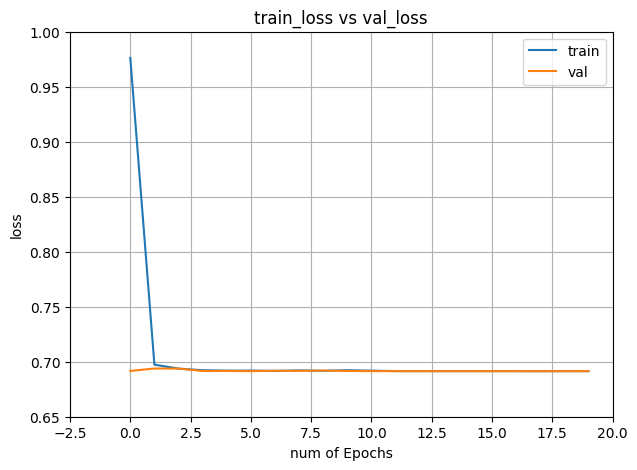

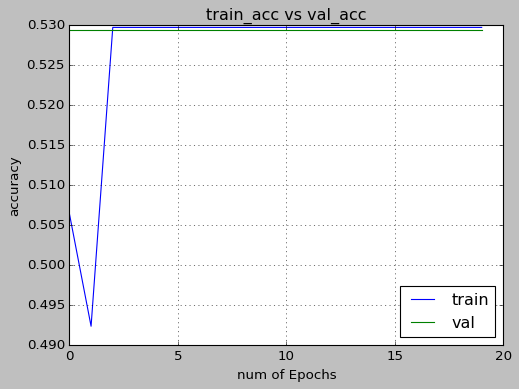

In [22]:
# Path definitions
dataset_path = "/content/drive/MyDrive/RealFake.zip (Unzipped Files)/real_and_fake_face"  # Update this path to your dataset location

# Data augmentation and preprocessing
data_with_aug = ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=False,
    rescale=1./255,
    validation_split=0.2,
    preprocessing_function=preprocess_input
)

train = data_with_aug.flow_from_directory(
    dataset_path,
    class_mode="binary",
    target_size=(224, 224),
    batch_size=32,
    subset="training"
)

val = data_with_aug.flow_from_directory(
    dataset_path,
    class_mode="binary",
    target_size=(224, 224),
    batch_size=32,
    subset="validation"
)

# Define a learning rate scheduler
def scheduler(epoch):
    if epoch <= 1:
        return 1.0
    elif epoch > 2 and epoch <= 10:
        return 0.1
    elif epoch > 10 and epoch <= 15:
        return 0.01
    else:
        return 0.001

lr_callbacks = LearningRateScheduler(scheduler)

# Model training
hist = model.fit(train, epochs=20, callbacks=[lr_callbacks], validation_data=val)

# Plotting training history
epochs = 20
train_loss = hist.history['loss']
val_loss = hist.history['val_loss']
train_acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
xc = range(epochs)

plt.figure(1, figsize=(7, 5))
plt.plot(xc, train_loss)
plt.plot(xc, val_loss)
plt.xlabel('num of Epochs')
plt.ylabel('loss')
plt.title('train_loss vs val_loss')
plt.grid(True)
plt.legend(['train', 'val'])
plt.style.use(['classic'])

plt.figure(2, figsize=(7, 5))
plt.plot(xc, train_acc)
plt.plot(xc, val_acc)
plt.xlabel('num of Epochs')
plt.ylabel('accuracy')
plt.title('train_acc vs val_acc')
plt.grid(True)
plt.legend(['train', 'val'], loc=4)
plt.style.use(['classic'])

plt.show()


In [23]:
def load_img(path):
    image = cv2.imread(path)
    image = cv2.resize(image,(224, 224))
    return image[...,::-1]

In [24]:
# Making predictions
predictions = model.predict(val)

val_path = "/content/drive/MyDrive/RealFake.zip (Unzipped Files)/real_and_fake_face/"

plt.figure(figsize=(15, 15))
start_index = 300

for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    preds = int(predictions[start_index+i][0] > 0.5)
    gt = val.filenames[start_index+i][9:13]

    gt = 0 if gt == "fake" else 1

    col = "r" if preds != gt else "g"
    plt.xlabel('i={}, pred={}, gt={}'.format(start_index+i, preds, gt), color=col)
    plt.imshow(load_img(val_path+val.filenames[start_index+i]))
    plt.tight_layout()

plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [25]:
model.save('/content/drive/MyDrive/hybrid_inception_lstm_model.h5')
print("Model saved as 'hybrid_inception_lstm_model.h5'")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved as 'hybrid_inception_lstm_model.h5'


In [ ]:
from tensorflow.keras.models import load_model

# Load the model
loaded_model = load_model('hybrid_inception_lstm_model.h5')
print("Model loaded from 'hybrid_inception_lstm_model.h5'")

# Verify the loaded model by printing the summary
loaded_model.summary()